There are 9 hardware shift position, in each hardware position shift there are 3 repetitions. In this approach, we train and test each hardware position shift seperately. In each hardware software shift we use 3 fold validation, train 2 repetitions and test the rest repetition. 
Noted: In training we only use virtual shifting in Self-supervised learning for better accuracy
We only consider 5 motions: 1Flexion, 2Extension, 7Open, 8close, 9rest

1. Define necessary modules, class, functions

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

features = ['RMS', 'MAV', 'SSC', 'ZC', 'WL']

DEVICE = torch.device("cpu")

def getFeatureMatrix(rawDataMatrix, window_size, overlap_factor):
    nChannels, nSamples = rawDataMatrix.shape
    stride = int(window_size * overlap_factor)
    num_stride = int(np.floor(nSamples/(window_size-stride)))
    featMatrix = np.zeros((nChannels*len(features),num_stride))
    # Define a dictionary that maps feature names to functions that calculate those features
    feature_functions = {
        'RMS': lambda x: np.sqrt(np.mean(x ** 2, axis=1)),
        'MAV': lambda x: np.mean(np.abs(x), axis=1),
        'SSC': lambda x: np.mean(((x[:, 1:-1] - x[:, :-2]) * (x[:, 2:] - x[:, 1:-1])) < 0, axis=1).reshape(-1, 1),
        'ZC': lambda x: np.mean((x[:, :-1] * x[:, 1:] < 0) & (np.abs(x[:, :-1] - x[:, 1:]) > 0), axis=1).reshape(-1, 1),
        'WL': lambda x: np.mean(np.abs(x[:, :-1] - x[:, 1:]), axis=1)
    }
    # Loop over the features 
    featIndex = 0
    for feature in features:
        if feature in feature_functions:
            featFunc = feature_functions[feature]
            for i in range(num_stride):
                wdwStrtIdx = i*(window_size-stride)
                if i == num_stride:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:nSamples] 
                else:
                    sigWin = rawDataMatrix[:, wdwStrtIdx:(wdwStrtIdx+window_size-1)] 
                
                featValues = featFunc(sigWin)
                featValues = featValues.flatten() # Flatten featValues before assigning it to featMatrix
                featMatrix[featIndex:featIndex + nChannels, i] = featValues     
            featIndex += nChannels
    return featMatrix

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Train and Test at the same physical position shifting itself: 3 fold validation

In [4]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1 * Fs))  # 100ms
windowOverlap = 0.5  # 50% overlap


X_train = [[np.zeros([0, 8 * 5]) for _ in range(3)] for _ in range(9)]
y_train = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]
X_test = [[np.zeros([0, 8 * 5]) for _ in range(3)] for _ in range(9)]
y_test = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]



for k_fold in range(0, 3): 
    for shift in range(0,9): 
        for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
            _, class_, _, rep_ = files.split('_')

            if class_ in ['1','2','7','8','9']:
                df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}', skiprows=0, sep=' ', header=None)
                data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range(8)])
                data_arr -= 121
                data_arr /= 255.0
                feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
                
                # Sum across each feature separately
                num_features = 5  # Number of features
                feature_sum = np.zeros((num_features, feaData.shape[1]))

                for f in range(num_features):
                    feature_sum[f] = feaData[f*8:(f+1)*8, :].sum(axis=0)
                
                if not class_.startswith('9'):
                    baseline = 2 * feature_sum.sum(axis=0)[-50:].mean()
                    start_ = np.argmax(feature_sum.sum(axis=0) > baseline)
                    end_ = len(feature_sum.sum(axis=0)) - np.argmax(feature_sum.sum(axis=0)[::-1] > baseline) - 1
                    feaData = feaData.T[start_:end_]
                else:
                    feaData = feaData.T
                
                
                if rep_.startswith(str(k_fold+1)):
                    X_test[shift][k_fold] = np.concatenate([X_test[shift][k_fold],feaData])
                    y_test[shift][k_fold] = np.concatenate([y_test[shift][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])
                else:
                    X_train[shift][k_fold] = np.concatenate([X_train[shift][k_fold],feaData])
                    y_train[shift][k_fold] = np.concatenate([y_train[shift][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])



In [4]:
print("Training dataset feature:")
print(X_train[1][0].shape)
print("Training dataset label:")
print(y_train[1][0].shape)
print("Testing dataset feature:")
print(X_test[1][0].shape)
print("Testing dataset label:")
print(y_test[1][0].shape)

Training dataset feature:
(2514, 40)
Training dataset label:
(2514,)
Testing dataset feature:
(1294, 40)
Testing dataset label:
(1294,)


2.2 Logistic Regression:

2.2.1: Training leanring model

In [5]:
for shift in range(9):
    for k_fold in range(3):
        reg = LogisticRegression(penalty='l2', C=100).fit(X_train[shift][k_fold], y_train[shift][k_fold])
        dump(reg, f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.joblib')

2.2.2 Testing accuracy

In [6]:
accuracies_LosReg_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        logRegres  = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.joblib')
        accuracy = logRegres.score(X_test[shift][k_fold],y_test[shift][k_fold])
        accuracies_LosReg_list[shift][k_fold]= accuracy
        print(f'Accuracy of shift {shift} fold {k_fold+1}:')
        print(accuracy)

Accuracy of shift 0 fold 1:
0.9983552631578947
Accuracy of shift 0 fold 2:
0.991283676703645
Accuracy of shift 0 fold 3:
0.985362095531587
Accuracy of shift 1 fold 1:
0.9860896445131375
Accuracy of shift 1 fold 2:
0.9692070823710547
Accuracy of shift 1 fold 3:
0.9958847736625515
Accuracy of shift 2 fold 1:
0.9844006568144499
Accuracy of shift 2 fold 2:
0.9377777777777778
Accuracy of shift 2 fold 3:
1.0
Accuracy of shift 3 fold 1:
0.9969040247678018
Accuracy of shift 3 fold 2:
0.9720965309200603
Accuracy of shift 3 fold 3:
0.9758490566037736
Accuracy of shift 4 fold 1:
0.9943593875906527
Accuracy of shift 4 fold 2:
0.9946112394149346
Accuracy of shift 4 fold 3:
0.9808868501529052
Accuracy of shift 5 fold 1:
0.9830769230769231
Accuracy of shift 5 fold 2:
0.9894736842105263
Accuracy of shift 5 fold 3:
0.9878787878787879
Accuracy of shift 6 fold 1:
0.8648867313915858
Accuracy of shift 6 fold 2:
0.9473282442748091
Accuracy of shift 6 fold 3:
0.9521640091116174
Accuracy of shift 7 fold 1:
0.

In [7]:
print(accuracies_LosReg_list)

[[0.9983552631578947, 0.991283676703645, 0.985362095531587], [0.9860896445131375, 0.9692070823710547, 0.9958847736625515], [0.9844006568144499, 0.9377777777777778, 1.0], [0.9969040247678018, 0.9720965309200603, 0.9758490566037736], [0.9943593875906527, 0.9946112394149346, 0.9808868501529052], [0.9830769230769231, 0.9894736842105263, 0.9878787878787879], [0.8648867313915858, 0.9473282442748091, 0.9521640091116174], [0.9976114649681529, 0.991466252909232, 0.9976851851851852], [0.9974226804123711, 1.0, 1.0]]


In [8]:
average_accuracies_LosReg_list = []
for accuracy in accuracies_LosReg_list:
    average_accuracies_LosReg_list.append(sum(accuracy)/3)

In [9]:
print(average_accuracies_LosReg_list)

[0.991667011797709, 0.9837271668489146, 0.9740594781974092, 0.9816165374305452, 0.9899524923861641, 0.9868097983887457, 0.9214596615926708, 0.9955876343541901, 0.9991408934707904]


In [10]:
value_average_accuracies_LosReg = sum(average_accuracies_LosReg_list) / 9 
print(value_average_accuracies_LosReg)

0.9804467416074599


2.2.3.2 Confusion matrix in each 9 hardwrae shifts between 9 classes

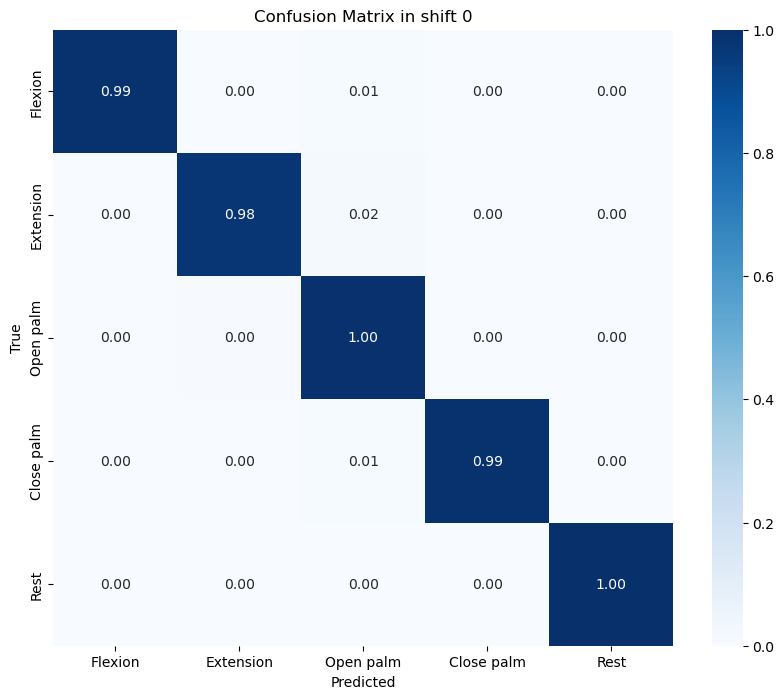

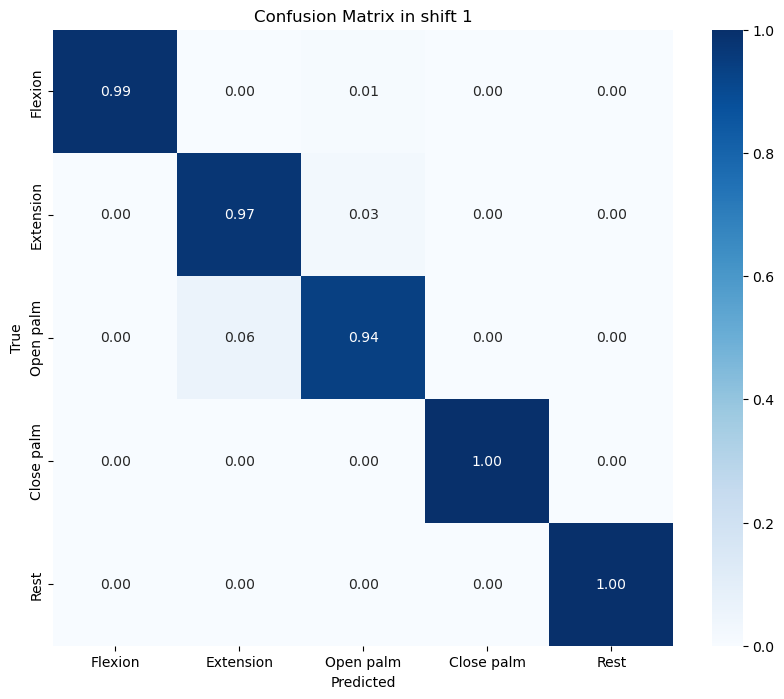

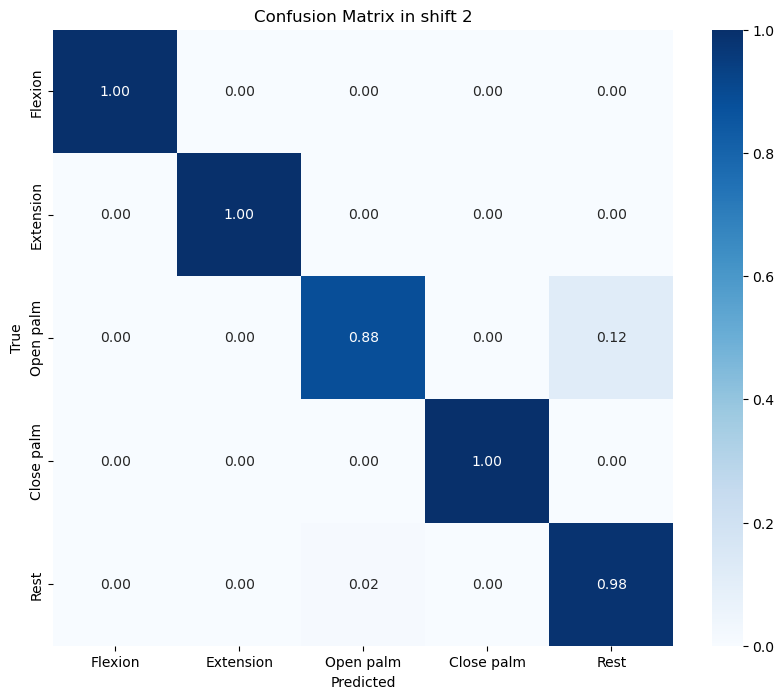

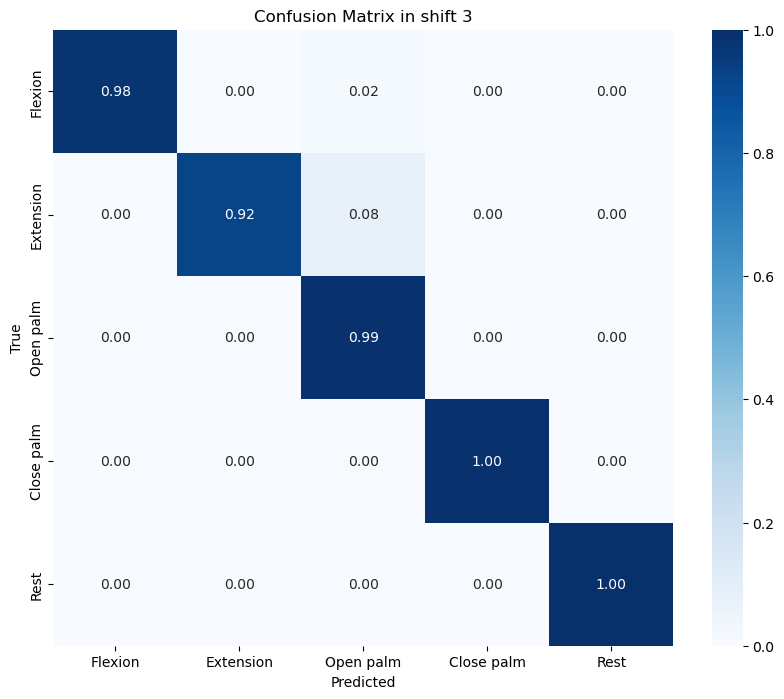

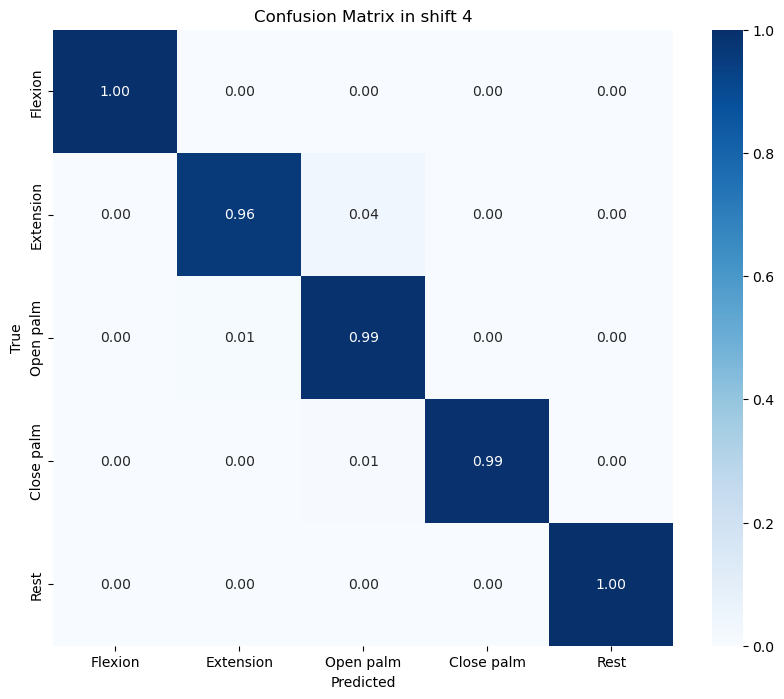

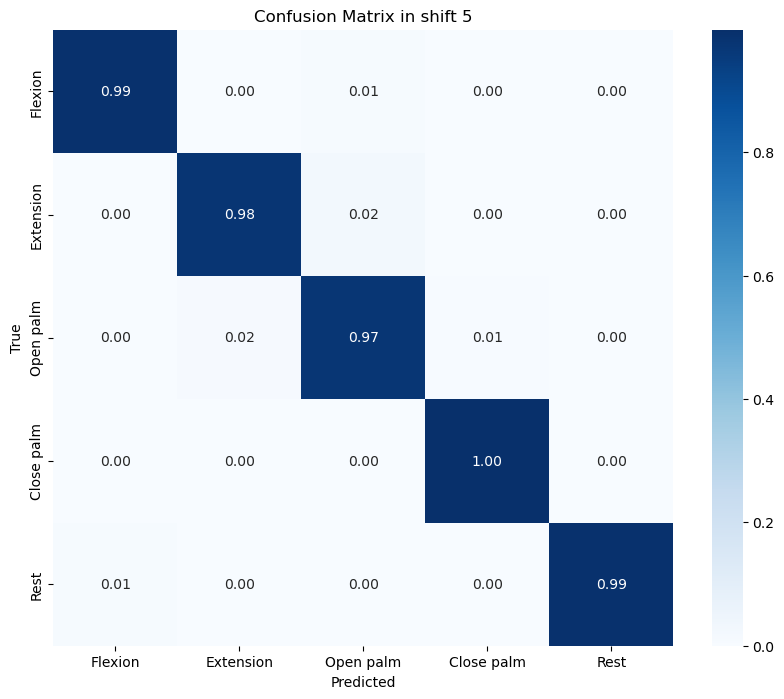

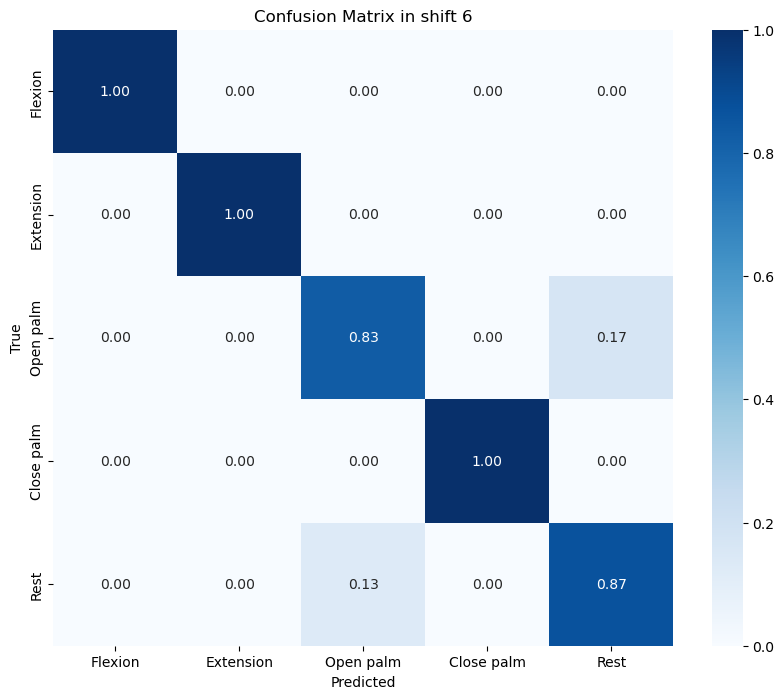

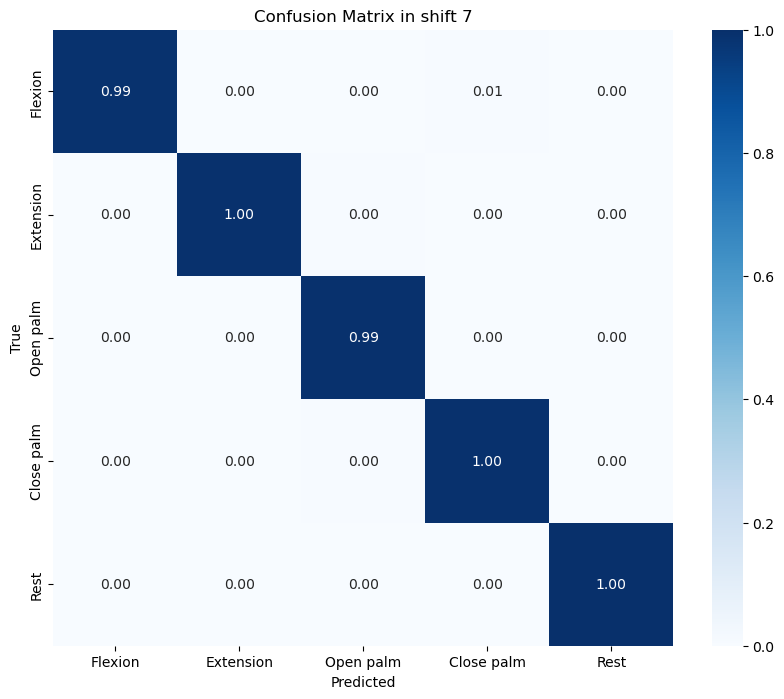

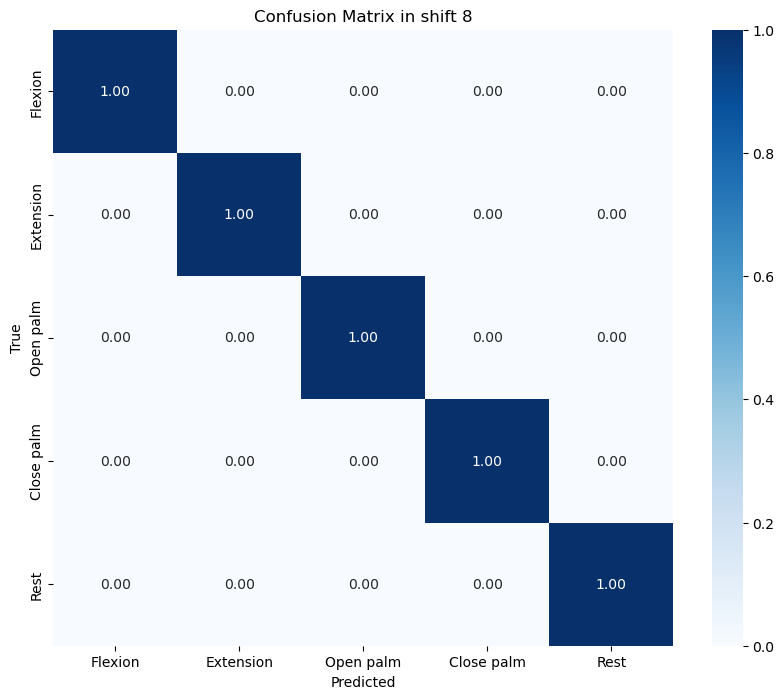

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']

conf_matrices_LogReg_list = []

# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        # Load the trained model
        reg = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.joblib')
        # Make predictions on the test data
        predictions = reg.predict(X_test[shift][k_fold])
        # Accumulate predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(y_test[shift][k_fold])
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_LogReg_list.append(conf_matrix)
    
    # Convert confusion matrix from counts to percentages
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix in shift {shift}')
    plt.show()



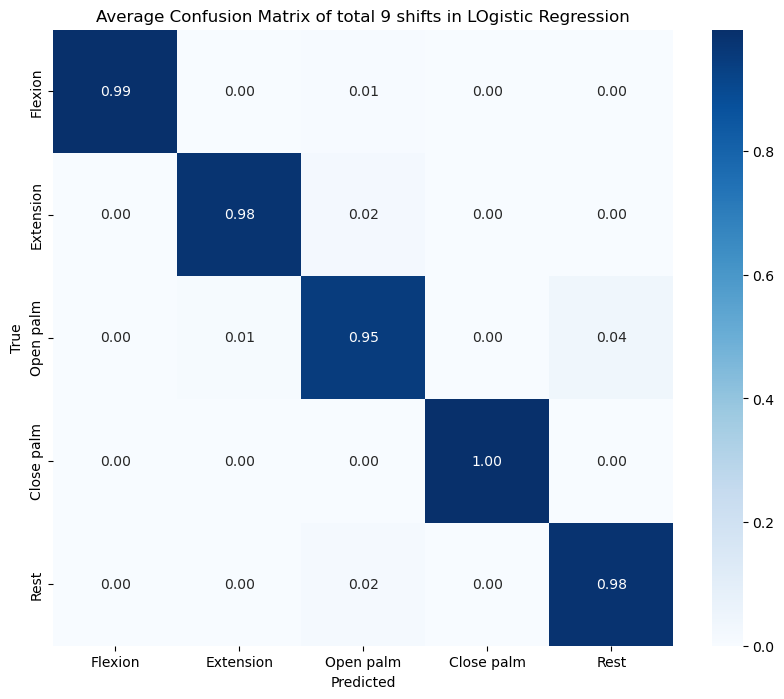

In [12]:
average_conf_matrix_LogReg = np.mean(conf_matrices_LogReg_list, axis=0)
average_total_LogReg_samples_per_class = np.sum(average_conf_matrix_LogReg, axis=1)
average_conf_LogReg_matrix_percent = average_conf_matrix_LogReg / average_total_LogReg_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf_LogReg_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts in LOgistic Regression')
plt.show()

2.3 Feed Forward Neural Network

In [13]:
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns


def get_all_data_full_feature(X, y, v_shift=None):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels

    if v_shift is None:
        all_X = np.zeros([X.shape[0], 8, num_channels * num_features], dtype='float32')
        all_y = np.zeros([y.shape[0], 8], dtype='float32')
        all_shift = np.zeros([y.shape[0], 8], dtype='int')

        for i, shift in enumerate(range(-4, 4)):
            X_i = roll_data(X, shift)
            all_X[:, i, :] = X_i
            all_y[:, i] = y
            all_shift[:, i] = shift

        return all_X.reshape(-1, num_channels * num_features), all_y.reshape(-1, 1), all_shift.reshape(-1, 1)
    else:
        shapes = [X_.shape[0] for X_ in X]
        all_shift = [np.ones(shape, dtype='int') * v_shift for (v_shift, shape) in zip(v_shift, shapes)]
        return np.concatenate(X).reshape(-1, num_channels * num_features), np.concatenate(y).reshape(-1, 1), np.concatenate(all_shift).reshape(-1, 1)


def get_shift_data_full_features(all_X, all_shift, all_y):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels
    feature_dim = num_channels * num_features

    # Combine features with shift values
    all_X_shift = np.concatenate([all_X, all_shift], axis=1)
    
    # Initialize arrays with correct dimensions
    all_X1 = np.zeros_like(all_X)
    all_X2 = np.zeros_like(all_X)
    all_y_ = np.zeros_like(all_y)
    all_shift_1 = np.zeros_like(all_y)
    all_shift_2 = np.zeros_like(all_y)

    for class_label in range(9):
        class_idx = all_y.flatten() == class_label
        class_data = all_X_shift[class_idx]
        class_data_clone = class_data.copy()
        np.random.shuffle(class_data_clone)

        all_X1[class_idx] = class_data[:, :-1]
        all_X2[class_idx] = class_data_clone[:, :-1]
        all_shift_1[class_idx] = class_data[:, -1:]
        all_shift_2[class_idx] = class_data_clone[:, -1:]
        all_y_[class_idx] = class_label

    return all_X1, all_X2, all_shift_1, all_shift_2, all_y_

2.3.1 Simulated data for training for Feed Forward Neural Network

In [14]:
alltrainloader_list = [[] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        all_train_dataset = CustomSignalData(get_tensor(X_train[shift][k_fold]), get_tensor(y_train[shift][k_fold]))
        alltrainloader = torch.utils.data.DataLoader(all_train_dataset, batch_size = 102, shuffle=True)
        alltrainloader_list[shift].append(alltrainloader)

for alltrainloader in alltrainloader_list:
    print(alltrainloader)

[<torch.utils.data.dataloader.DataLoader object at 0x79aff06151b0>, <torch.utils.data.dataloader.DataLoader object at 0x79aefddcb850>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb17af0>]
[<torch.utils.data.dataloader.DataLoader object at 0x79aefdc1eb00>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb546d0>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb54730>]
[<torch.utils.data.dataloader.DataLoader object at 0x79aefdb54760>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb568f0>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb56740>]
[<torch.utils.data.dataloader.DataLoader object at 0x79aefdb56a70>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb56aa0>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb55630>]
[<torch.utils.data.dataloader.DataLoader object at 0x79aefdb552d0>, <torch.utils.data.dataloader.DataLoader object at 0x79aefdb54100>, <torch.utils.data.dataloader.DataLoader object at 0x79aef

2.3.2 Training Feed Forward Neural Network

In [15]:
inputDim = 40     # takes variable 'x' 
outputDim = 9      # takes variable 'y'
learningRate = 0.005

for shift in range(9):
    for k_fold in range(3):
        model = FFNN(inputDim, outputDim)
        model = model.to(DEVICE)

        crit = torch.nn.CrossEntropyLoss()
        acc_record = []
        params_clf = list(model.parameters())# + list(encoder.parameters())
        optim = torch.optim.Adam(params_clf, lr=learningRate)

        epochs = 200
        #encoder = encoder.to(device)
        for epoch in range(epochs):
            model.train()

            # Converting inputs and labels to Variable
            for inputs, labels, _, _ in alltrainloader_list[shift][k_fold]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                labels = labels.long()
                labels = labels.flatten()
                outputs = model(inputs, None)
                optim.zero_grad()
                # get loss for the predicted output
                losss = crit(outputs, labels) #+ 0.001 * model.l1_regula()
                # get gradients w.r.t to parameters
                losss.backward()
                # update parameters
                optim.step()

        torch.save(model.state_dict(), f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")


2.3.3 Testing accuracy of Feed Forward Neural Network

2.3.3.1 Accuracy of each 9 hardware shift with 3 accuracies in each represnt for 3 folds

In [5]:
accuracies_FFNN_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        modelWOoperator = FFNN(40,9)
        modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")) # loaded from the file: parameters learned during training.
        modelWOoperator.eval()

        test_shift_dataset = CustomSignalData(get_tensor(X_test[shift][k_fold]), get_tensor(y_test[shift][k_fold]))
        testshiftloader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)
        accuracies_FFNN_list[shift][k_fold] = clf_acc(modelWOoperator, testshiftloader, encoder = None)

for accuracy in accuracies_FFNN_list:
    print(accuracy)

[0.9991830061463749, 0.9976415083093463, 0.9909090876579285]
[0.9899691332269598, 0.9424242409792813, 0.9910130676101235]
[0.9959150307318744, 0.9400584750008165, 0.9991830061463749]
[0.9922839469379849, 0.9732142814568111, 0.9761904744165284]
[0.9879807646457965, 0.9939393910494718, 0.9924242388118397]
[0.9931818160143766, 0.9895833283662796, 0.9840909025885842]
[0.868589746264311, 0.9515151457353072, 0.9522727261890065]
[0.9968553444124618, 0.9945987628565894, 0.9969135787751939]
[1.0, 1.0, 1.0]


In [6]:
average_accuracies_FFNN = []
for accuracy in accuracies_FFNN_list:
    average_accuracies_FFNN.append(sum(accuracy)/3)

print(average_accuracies_FFNN)

[0.99591120070455, 0.9744688139387883, 0.9783855039596886, 0.9805629009371083, 0.9914481315023694, 0.9889520156564134, 0.9241258727295415, 0.9961225620147484, 1.0]


In [7]:
value_average_accuracies_FFNN = sum(average_accuracies_FFNN) / 9 
print(value_average_accuracies_FFNN)

0.9811085557159119


2.3.4.2 Confusion matrix in each 9 hardwrae shifts between 9 classes

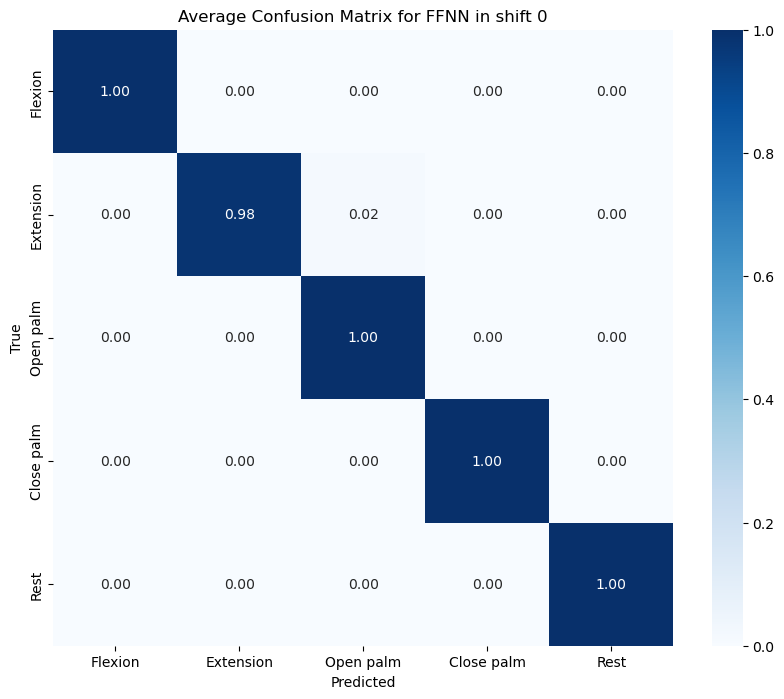

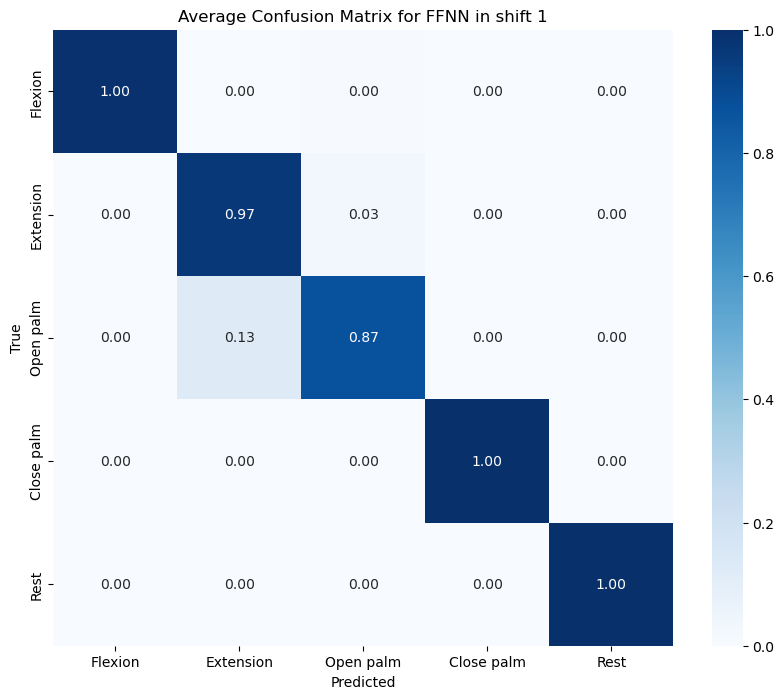

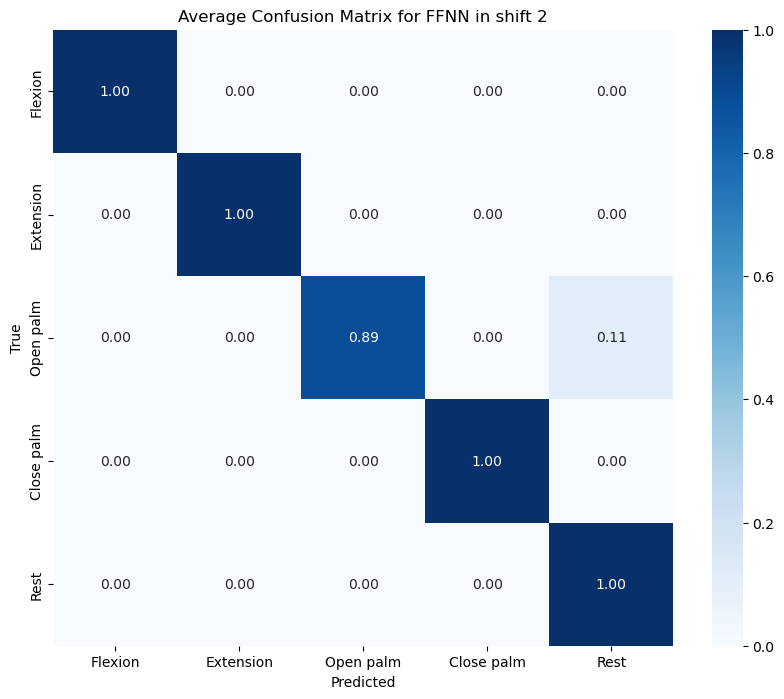

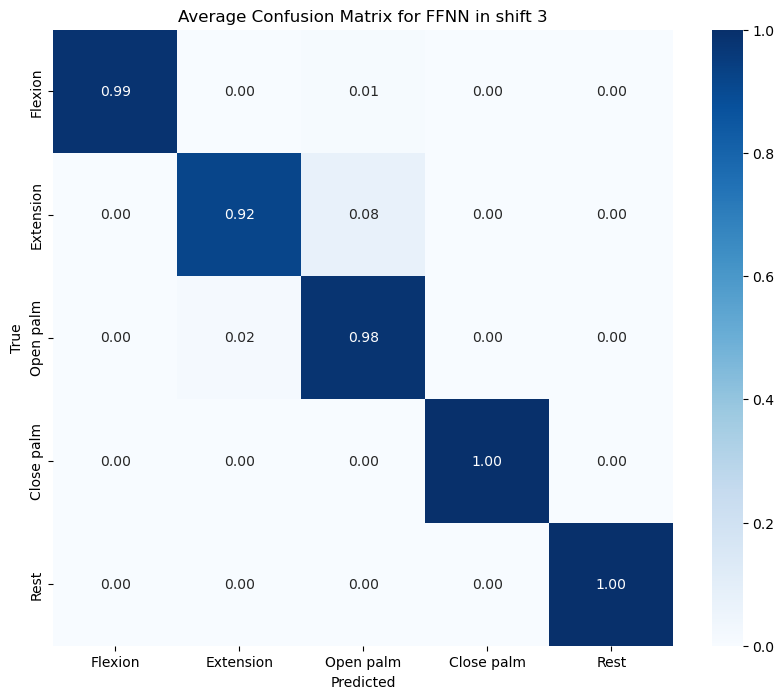

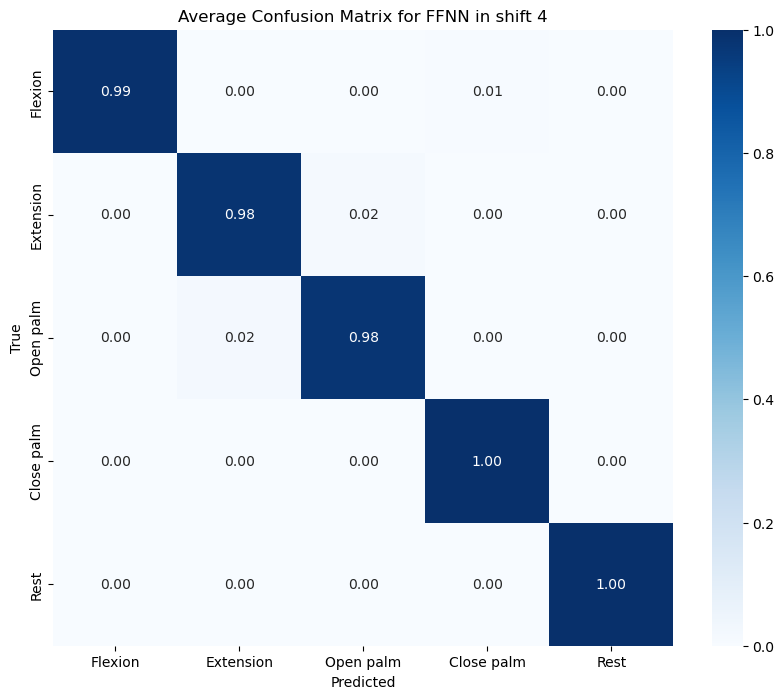

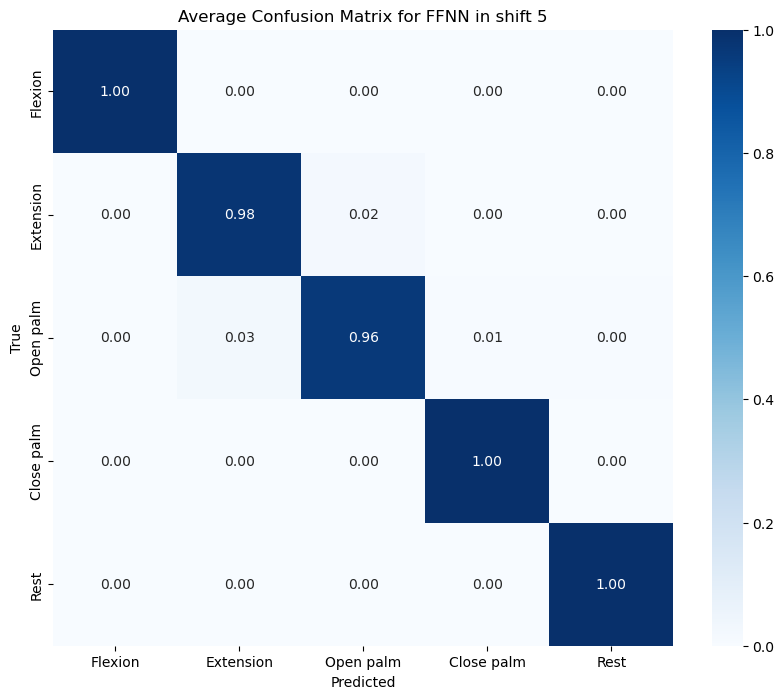

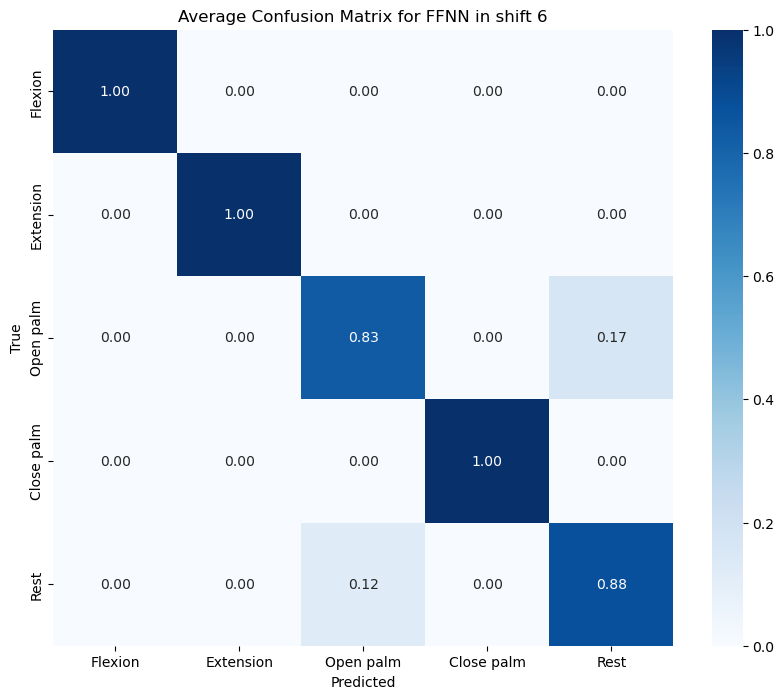

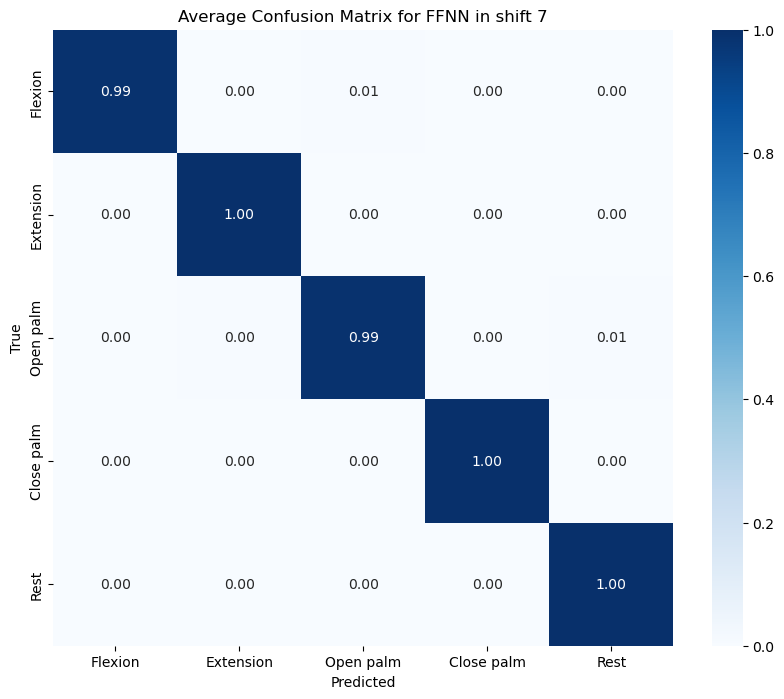

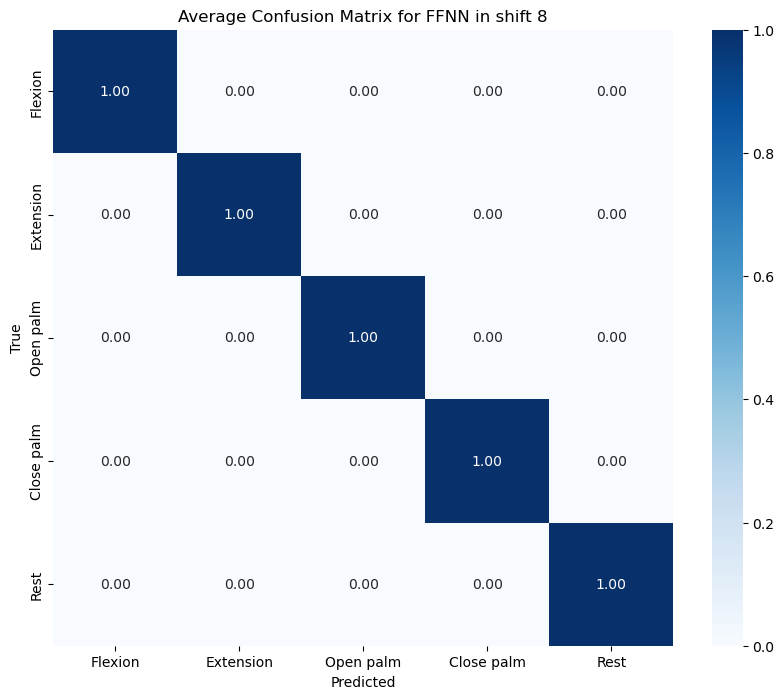

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class names
class_names = ['Flexion', 'Extension',  'Open palm', 'Close palm', 'Rest']
# Initialize variables to accumulate predictions and true labels
conf_matrices_FFNN = []

# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        # Load the trained model
        modelWOoperator = FFNN(40, 9)
        modelWOoperator.load_state_dict(torch.load(f"modelwoOperator_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt"))
        modelWOoperator.eval()

        # Prepare the test dataset
        test_shift_dataset = CustomSignalData(get_tensor(X_test[shift][k_fold]), get_tensor(y_test[shift][k_fold]))
        test_shift_loader = torch.utils.data.DataLoader(test_shift_dataset, batch_size=24, shuffle=True)

        with torch.no_grad():
            for inputs, labels,_,_ in test_shift_loader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                pred = modelWOoperator(inputs)
                predicted = torch.argmax(pred,dim = 1)
                all_predictions.extend(predicted.tolist())
                all_true_labels.extend(labels.tolist())


        # # Evaluate the model and accumulate predictions and true labels
        # predictions, true_labels = clf_predictions(modelWOoperator, test_shift_loader, encoder=None)
        # all_predictions.extend(predictions)
        # all_true_labels.extend(true_labels)
        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_FFNN.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]

    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for FFNN in shift {shift}')
    plt.show()



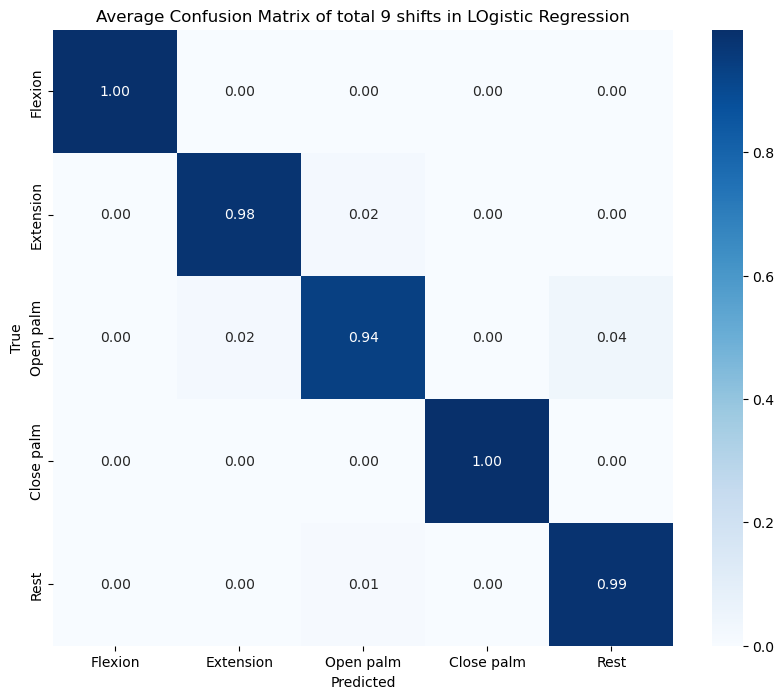

In [22]:
average_conf_matrix_FFNN = np.mean(conf_matrices_FFNN, axis=0)
average_total_samples_per_class_FFNN = np.sum(average_conf_matrix_FFNN, axis=1)
average_conf_matrix_percent_FFNN = average_conf_matrix_FFNN / average_total_samples_per_class_FFNN[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_conf_matrix_percent_FFNN, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts in LOgistic Regression')
plt.show()

2.4 Self-supervised learning

In [10]:
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns


def get_all_data_full_feature(X, y, v_shift=None):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels

    if v_shift is None:
        all_X = np.zeros([X.shape[0], 8, num_channels * num_features], dtype='float32')
        all_y = np.zeros([y.shape[0], 8], dtype='float32')
        all_shift = np.zeros([y.shape[0], 8], dtype='int')

        for i, shift in enumerate(range(-4, 4)):
            X_i = roll_data(X, shift)
            all_X[:, i, :] = X_i
            all_y[:, i] = y
            all_shift[:, i] = shift

        return all_X.reshape(-1, num_channels * num_features), all_y.reshape(-1, 1), all_shift.reshape(-1, 1)
    else:
        shapes = [X_.shape[0] for X_ in X]
        all_shift = [np.ones(shape, dtype='int') * v_shift for (v_shift, shape) in zip(v_shift, shapes)]
        return np.concatenate(X).reshape(-1, num_channels * num_features), np.concatenate(y).reshape(-1, 1), np.concatenate(all_shift).reshape(-1, 1)


def get_shift_data_full_features(all_X, all_shift, all_y):
    num_features = 5  # Number of features in the feature matrix
    num_channels = 8  # Number of channels
    feature_dim = num_channels * num_features

    # Combine features with shift values
    all_X_shift = np.concatenate([all_X, all_shift], axis=1)
    
    # Initialize arrays with correct dimensions
    all_X1 = np.zeros_like(all_X)
    all_X2 = np.zeros_like(all_X)
    all_y_ = np.zeros_like(all_y)
    all_shift_1 = np.zeros_like(all_y)
    all_shift_2 = np.zeros_like(all_y)

    for class_label in range(9):
        class_idx = all_y.flatten() == class_label
        class_data = all_X_shift[class_idx]
        class_data_clone = class_data.copy()
        np.random.shuffle(class_data_clone)

        all_X1[class_idx] = class_data[:, :-1]
        all_X2[class_idx] = class_data_clone[:, :-1]
        all_shift_1[class_idx] = class_data[:, -1:]
        all_shift_2[class_idx] = class_data_clone[:, -1:]
        all_y_[class_idx] = class_label

    return all_X1, all_X2, all_shift_1, all_shift_2, all_y_



In [11]:
triplettrainloader_list = [[] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        all_X_train, all_y_train, all_shift_train = get_all_data_full_feature(X_train[shift][k_fold], y_train[shift][k_fold])
        all_X1_train, all_X2_train, all_shift_1_train, all_shift_2_train, all_y_shift_train = get_shift_data_full_features(all_X_train, all_shift_train, all_y_train)

        triplet_train_dataset = CustomSignalData1(get_tensor(all_X1_train), get_tensor(all_X2_train), get_tensor(all_shift_1_train), get_tensor(all_shift_2_train), get_tensor(all_y_shift_train))
        triplettrainloader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size = 102, shuffle=True)
        triplettrainloader_list[shift].append(triplettrainloader)

In [12]:
for triplettrainloader in triplettrainloader_list:
    print(triplettrainloader)

[<torch.utils.data.dataloader.DataLoader object at 0x7c44e4d08430>, <torch.utils.data.dataloader.DataLoader object at 0x7c45daf2df30>, <torch.utils.data.dataloader.DataLoader object at 0x7c44e4eafdf0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7c44e4f8b100>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d8504040>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d8504dc0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7c45d8506ad0>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d8507700>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d8507fa0>]
[<torch.utils.data.dataloader.DataLoader object at 0x7c45d8507370>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d85064a0>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d8504d60>]
[<torch.utils.data.dataloader.DataLoader object at 0x7c45d8504550>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d85048b0>, <torch.utils.data.dataloader.DataLoader object at 0x7c45d

2.4.2 Training Self-supervised learning

In [13]:
for shift in range(9):
    for k_fold in range(3):
        all_X_train, all_y_train, all_shift_train = get_all_data_full_feature(X_train[shift][k_fold], y_train[shift][k_fold])

        encoder = E(40,8)
        encoder.to(DEVICE)
        classifier = FFNN(8,9)
        classifier.to(DEVICE)

        parameters = list(encoder.parameters()) + list(classifier.parameters())

        crit1 = torch.nn.MSELoss()
        crit2 = torch.nn.CrossEntropyLoss()
        crit1.to(DEVICE)
        crit2.to(DEVICE)
        loss_record = []

        optimizer = torch.optim.Adam(parameters, lr=0.002)
        n_epochs = 50

        for epoch in range(0,n_epochs):
            encoder.train()
            classifier.train()
            for inputs1, inputs2, shift1, shift2, labels, _ in triplettrainloader_list[shift][k_fold]:
                inputs1 = inputs1.to(DEVICE)
                inputs2 = inputs2.to(DEVICE)
                shift1 = -shift1.int().flatten().to(DEVICE)
                shift2 = -shift2.int().flatten().to(DEVICE)
                labels = labels.long().flatten().to(DEVICE)
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                y1 = encoder(inputs1)
                y_tr_est1 = rotate_batch(y1,shift1,6)
                y_tr1 = classifier(y_tr_est1)


                y2 = encoder(inputs2)
                y_tr_est2 = rotate_batch(y2,shift2,6)
                y_tr2 = classifier(y_tr_est2)

                loss =  crit1(y_tr_est1, y_tr_est2) + 0.5*crit2(y_tr1,labels)+ 0.5*crit2(y_tr2,labels)
                loss.backward()
                optimizer.step()

        torch.save(classifier.state_dict(), f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")
        torch.save(encoder.state_dict(), f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")
        with torch.no_grad():
            encoder.eval()
            N_points = 1000
            rand_idx = np.random.choice(all_X_train.shape[0], N_points)
            y_tr = encoder(get_tensor(all_X_train[rand_idx]))
            recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
            del y_tr

        torch.save(recovered_points_, f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")

2.4.3 Testing accuracy of SElf-supervised learning

In [17]:
DEVICE = torch.device("cpu") # operations is in CPU or GPU.
M = torch.diag(torch.ones(8)).roll(-1,1) # Create a diagnoise matrix then shift it to the right
used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)] #

N_points = 1000

accuracies_self_supervised_list = [[0 for _ in range(3)] for _ in range(9)]

for shift in range(9):
    for k_fold in range(3):
        classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
        encoder = E(40,8)
        encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")) # contains the learned parameters (weights and biases) of the encoder model
        recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt") # These points represent reference points for inference or evaluation in the model
        classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")) # contains the weights and biases learned during training.
        classifier.eval() # sets the model to evaluation mode.
        encoder.eval() # sets the model to evaluation mode.

        # Get the test data for the current shift and fold
        X_test_shift = X_test[shift][k_fold]

        # Encode the test data using the encoder model
        y1 = encoder(get_tensor(X_test_shift))

        # Use the encoded data directly without rotation
        y_tr1 = classifier(y1).argmax(1)

        # Calculate accuracy and append to list
        accuracies_self_supervised_list[shift][k_fold] = (1 - torch.abs(torch.sign(y_tr1 - get_tensor(y_test[shift][k_fold]).flatten()))).mean().item()
for accuracy in accuracies_self_supervised_list:
    print(accuracy)

[0.9983552694320679, 0.996038019657135, 0.9522342085838318]
[0.9922720193862915, 0.9638183116912842, 0.9934156537055969]
[0.9835796356201172, 0.9392592310905457, 1.0]
[0.9744582176208496, 0.9894419312477112, 0.9758490324020386]
[0.9871071577072144, 0.9961509108543396, 0.9984709620475769]
[0.9961538314819336, 0.9932330846786499, 0.9742424488067627]
[0.8794498443603516, 0.9519084095954895, 0.9529232978820801]
[0.9984076619148254, 0.9883630871772766, 0.9984567761421204]
[1.0, 1.0, 1.0]


In [18]:
average_accuracies_self_supervised = []
for accuracy in accuracies_self_supervised_list:
    average_accuracies_self_supervised.append(sum(accuracy)/3)

print(average_accuracies_self_supervised)

[0.9822091658910116, 0.9831686615943909, 0.9742796222368876, 0.9799163937568665, 0.9939096768697103, 0.9878764549891154, 0.9280938506126404, 0.9950758417447408, 1.0]


In [19]:
value_average_accuracies_self_supervised = sum(average_accuracies_self_supervised) / 9 
print(value_average_accuracies_self_supervised)

0.9805032964105957


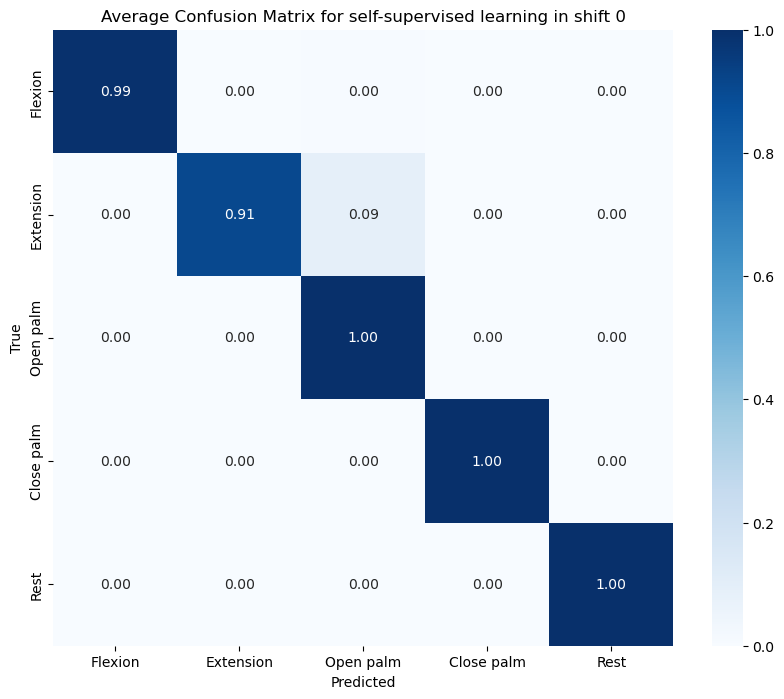

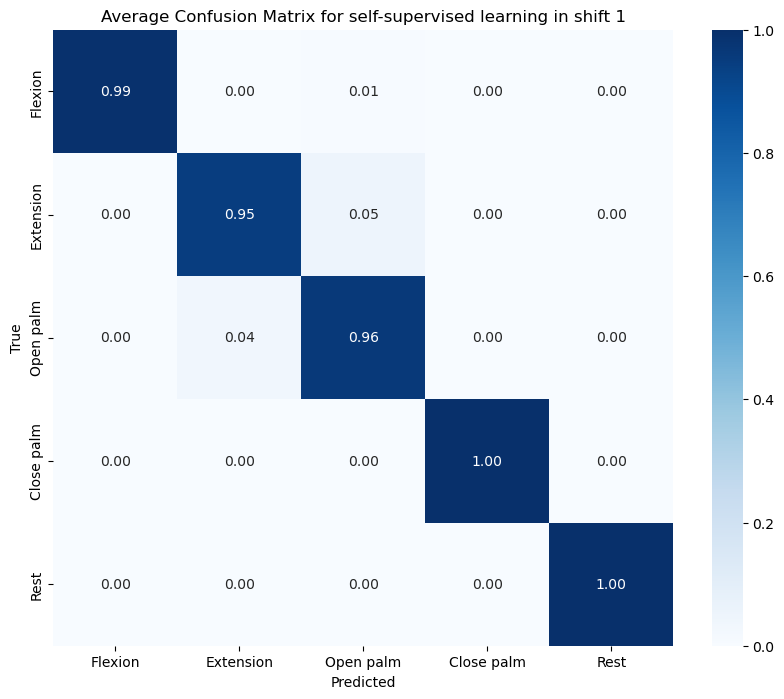

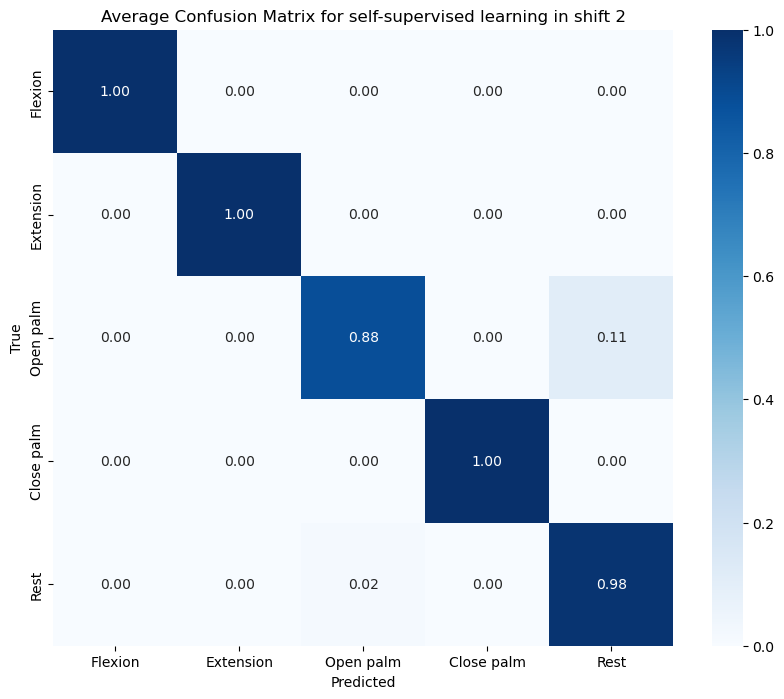

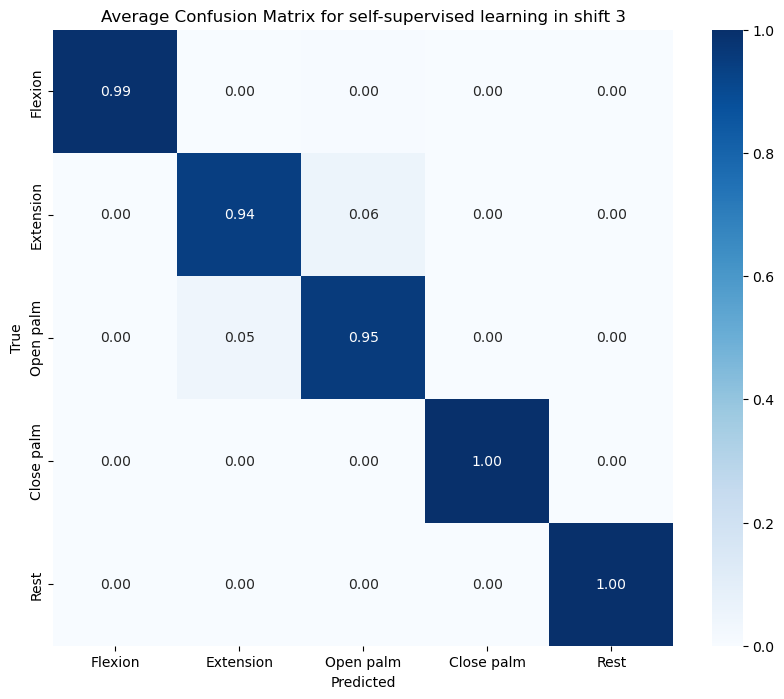

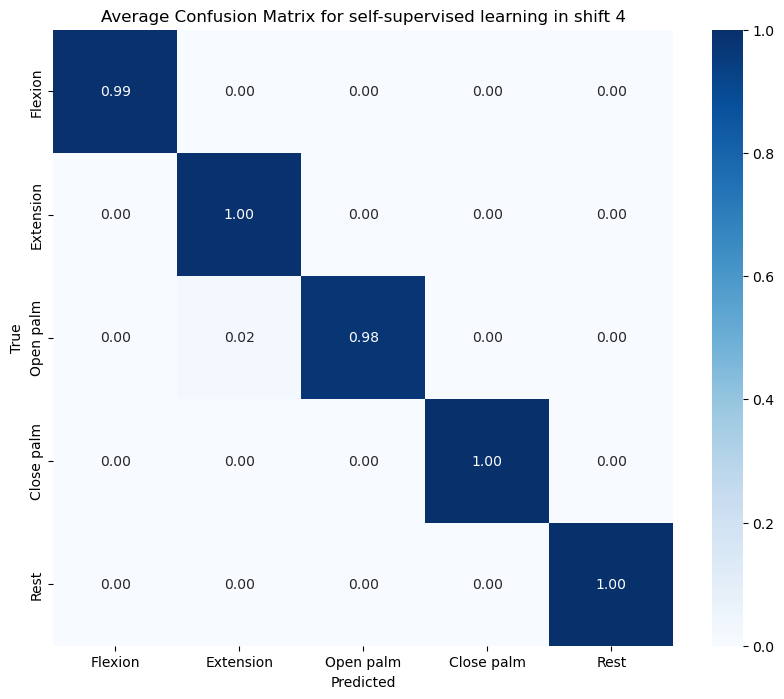

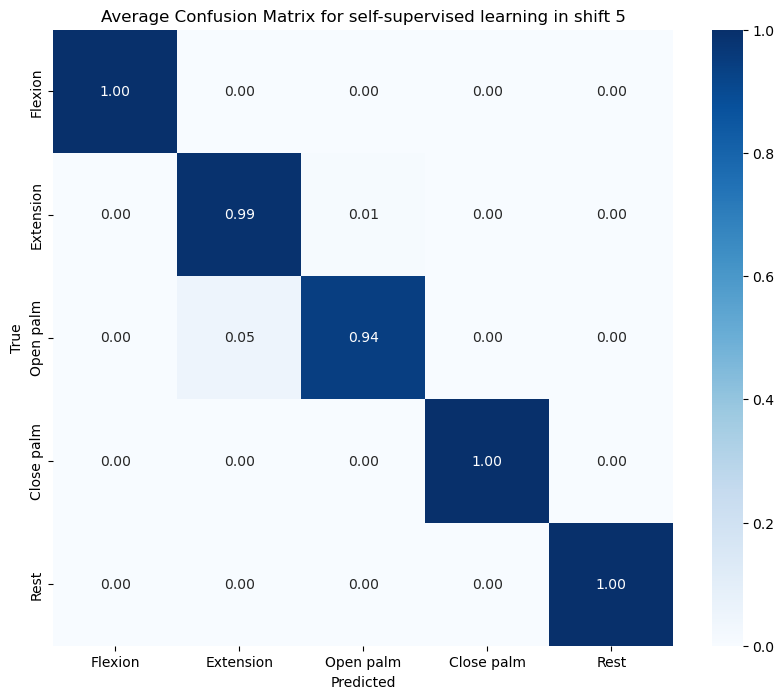

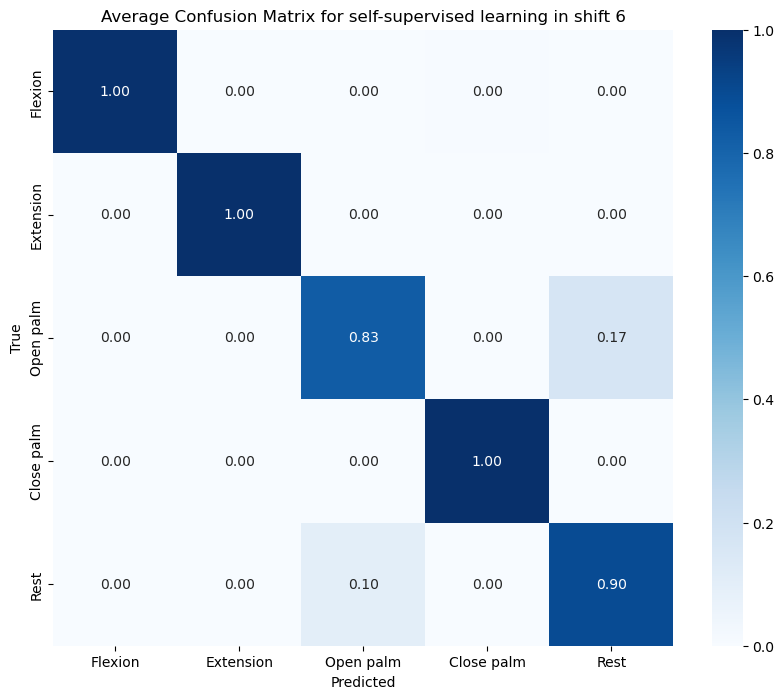

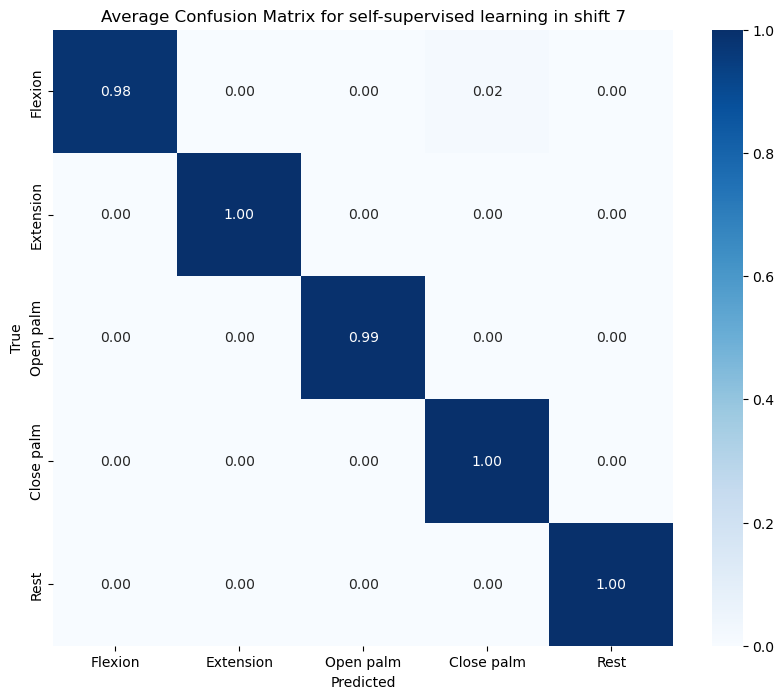

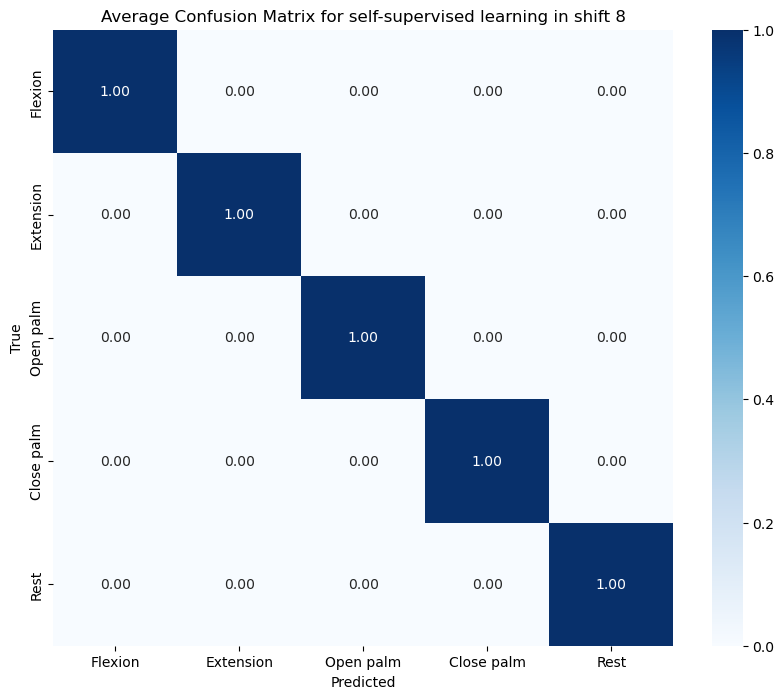

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize variables to accumulate predictions and true labels
conf_matrices_self_supervised = []
class_names = ['Flexion', 'Extension', 'Open palm', 'Close palm', 'Rest']
# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):
        #classifier = FFNN(8,9) # This indicates that the neural network expects input data with 8 features and will produce output predictions across 9 classes.
        encoder = E(40,8)
        encoder.load_state_dict(torch.load(f"encoder_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")) # contains the learned parameters (weights and biases) of the encoder model
        recovered_points_= torch.load(f"reference_points_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt") # These points represent reference points for inference or evaluation in the model
        classifier.load_state_dict(torch.load(f"classifier_fold_{k_fold+1}_shift_{shift}_app1_5motions_full_features.pt")) # contains the weights and biases learned during training.
        classifier.eval() # sets the model to evaluation mode.
        encoder.eval() # sets the model to evaluation mode.

        # Get the test data for the current shift and fold
        X_test_shift = X_test[shift][k_fold]
        # Encode the test data using the encoder model
        y1 = encoder(get_tensor(X_test_shift))
        # Use the encoded data directly without rotation
        y_tr1 = classifier(y1).argmax(1)

        all_predictions.extend(y_tr1.cpu().numpy())
        all_true_labels.extend(get_tensor(y_test[shift][k_fold]).flatten())

        
    # Calculate the confusion matrix for the current shift
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_self_supervised.append(conf_matrix)

    total_samples_per_class = np.sum(conf_matrix, axis=1)
    conf_matrix_percent = conf_matrix / total_samples_per_class[:, None]


    # Plot the average confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Average Confusion Matrix for self-supervised learning in shift {shift}')
    plt.show()

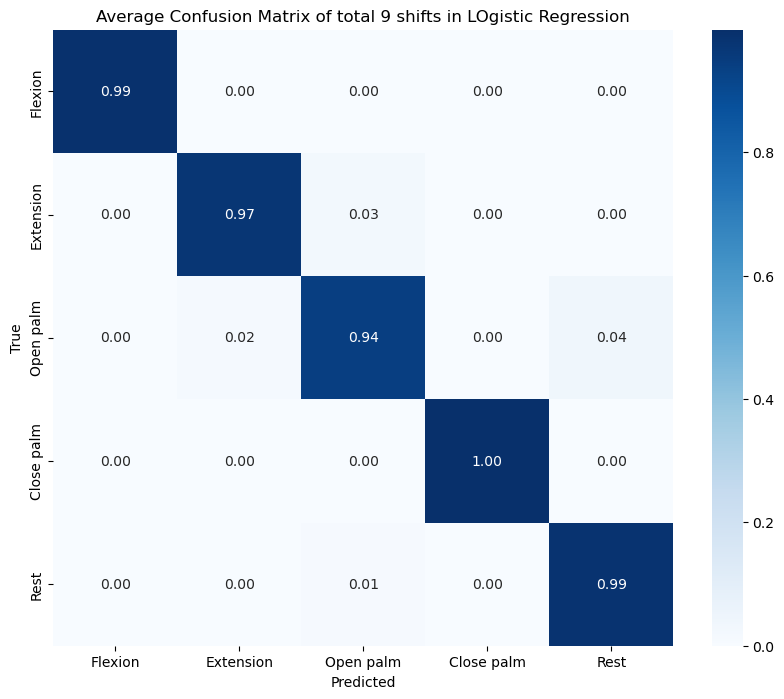

In [22]:

average_conf_matrix__self_supervised = np.mean(conf_matrices_self_supervised, axis=0)
average_total__self_supervised_samples_per_class = np.sum(average_conf_matrix__self_supervised, axis=1)
average_conf__self_supervised_matrix_percent = average_conf_matrix__self_supervised / average_total__self_supervised_samples_per_class[:, None]
# Plot the average confusion matrix
plt.figure(figsize=(10, 8))

sns.heatmap(average_conf__self_supervised_matrix_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts in LOgistic Regression')
plt.show()

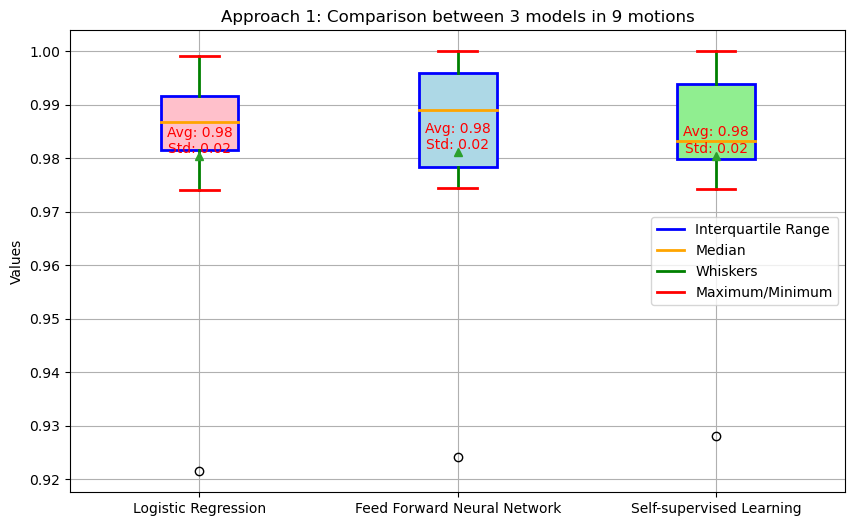

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = [
    [0.991667011797709, 0.9837271668489146, 0.9740594781974092, 0.9816165374305452, 0.9899524923861641, 0.9868097983887457, 0.9214596615926708, 0.9955876343541901, 0.9991408934707904],
    [0.99591120070455, 0.9744688139387883, 0.9783855039596886, 0.9805629009371083, 0.9914481315023694, 0.9889520156564134, 0.9241258727295415, 0.9961225620147484, 1.0],
    [0.9822091658910116, 0.9831686615943909, 0.9742796222368876, 0.9799163937568665, 0.9939096768697103, 0.9878764549891154, 0.9280938506126404, 0.9950758417447408, 1.0]
]

# Calculate average and standard deviation
averages = [np.mean(lst) for lst in data]
std_devs = [np.std(lst) for lst in data]

# Plot boxplot with customized colors and statistics
plt.figure(figsize=(10, 6))
colors = ['pink', 'lightblue', 'lightgreen']
boxprops = dict(color="blue", linewidth=2)
medianprops = dict(color="orange", linewidth=2)
whiskerprops = dict(color="green", linewidth=2)
capprops = dict(color="red", linewidth=2)
box = plt.boxplot(data, showmeans=True, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


plt.xticks([1, 2, 3], ['Logistic Regression', 'Feed Forward Neural Network', 'Self-supervised Learning'])
plt.ylabel('Values')
plt.title('Approach 1: Comparison between 3 models in 9 motions')
plt.grid(True)

# Add average and standard deviation text
for i in range(len(data)):
    plt.text(i + 1, averages[i], f'Avg: {averages[i]:.2f}\nStd: {std_devs[i]:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

# Add legend explaining box components
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, label='Interquartile Range'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Median'),
    plt.Line2D([0], [0], color='green', lw=2, label='Whiskers'),
    plt.Line2D([0], [0], color='red', lw=2, label='Maximum/Minimum')
]
plt.legend(handles=legend_elements)

plt.show()
